## Tuning Adam and NosAdam on CNN with CIFAR10 dataset

# 1.Imports & environment

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import sys
import pickle
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Setup predictable randomization
seed = 10
np.random.seed(seed)

# Setup CUda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loading and preparing the data
Here, we use CIFAR10 dataset containing 60k $32\times32$ colored images from 10 different classes (labels): plane, car, bird, cat, deer, dog, frog, horse, ship, and truck.

### 2.1. Definition of methods to extract data and labels
source: https://stackoverflow.com/questions/37512290/reading-cifar10-dataset-in-batches

In [ ]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'drive/MyDrive/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    return X_train, y_train, X_test, y_test

### 2.2. Load data

In [ ]:
train_images, train_labels, test_images, test_labels = get_CIFAR10_data(num_training=50000, num_test=10000)

### 2.3. Convert data from numpy arrays to torch tensors

In [ ]:
features_train=torch.from_numpy(train_images).to(device)
features_test=torch.from_numpy(test_images).to(device)
print('Training features:', features_train.shape, '\n'
'Testing features:', features_test.shape)

labels_train=torch.from_numpy(train_labels).to(device)
labels_test=torch.from_numpy(test_labels).to(device)
print('Training labels:', labels_train.shape, '\n'
'Testing labels:', labels_test.shape)

Training features: torch.Size([50000, 3072]) 
Testing features: torch.Size([10000, 3072])
Training labels: torch.Size([50000]) 
Testing labels: torch.Size([10000])


### 2.4. Normalize data

In [ ]:
mean, std = features_train.float().mean(), features_train.float().std()

features_train = features_train.float().sub_(mean).div_(std)
features_test = features_test.float().sub_(mean).div_(std)

In [ ]:
#reshape to make the 1st channel be a batch size

features_train = features_train.reshape(-1, 3, 32, 32)
features_test = features_test.reshape(-1, 3, 32, 32)

# 3. Setting up networks and evaluation methods

### 3.1. Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
   def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=5, stride=1, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same')
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 10)

   def forward(self, input:torch.Tensor) -> torch.Tensor:
        pool1 = torch.max_pool2d(F.relu(self.conv1(input)), kernel_size=2, stride=2)
        pool2 = torch.max_pool2d(F.relu(self.conv2(pool1)), kernel_size=2, stride=2)
        res = pool2.reshape(-1, 64*8*8)
        hidden = F.relu(self.fc1(res))
        output = self.fc2(hidden)

        return output

### 3.2. Implementation of method for training

In [ ]:
def run_nn(x_train, y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch):

    loss_train_ret = 0
    loss_test_ret = 0
    loss_train = 0
            
    for epoch in range(num_epoch):
        for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        if epoch == num_epoch - 1:

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            
            loss_train_ret = loss_train
            loss_test_ret = loss_test
            
            print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

    return loss_train_ret, loss_test_ret

# 4. Metrics of our tuning protocol
At this stage, we want to select the hyperparameter search space for each optimizer. This way, we can first tune the hyperparameters of each optimizer separately and then select the trial that achieved lowest final validation error.
We then comapre the optimizers' performance by looking at the validation and test errors as suggested in the paper "On empirical comparisons of optimizers for deep learning".

No regularization is used.

### 4.1. Tuning Adam for the CNN on CIFAR10
The hyperparameters we are tuning are alpha_0/epsilon, 1 - beta_1, 1 - beta_2, epsilon.
The final search spaces are suggested based on the experience of the writers of the same paper, "On empirical comparisons of optimizers for deep learning".

##### Set up model for training

In [ ]:
# Model fixed parameters
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device) # good loss function for classification tasks
num_epoch = 50
size_minibatch = 128

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### Tune to find best parameter
We perform trials until we have K of them, then we pick the best based on our statistic of interest

##### Set up parameters and search space for the final trial

In [ ]:
N = 200
K = 50 # Number of trials being kept for the statistic

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

Final, Train Loss: 2.3004, Test Loss: 2.3059
Final, Train Loss: 1.4072, Test Loss: 1.2655
Final, Train Loss: 2.3045, Test Loss: 2.3033
Final, Train Loss: 2.3032, Test Loss: 2.3037
Final, Train Loss: 2.3067, Test Loss: 2.3047
Final, Train Loss: 0.4793, Test Loss: 13.0637
Final, Train Loss: 2.2789, Test Loss: 2.2826
Final, Train Loss: 0.1766, Test Loss: 15.7397
Final, Train Loss: 2.3004, Test Loss: 2.3057
Final, Train Loss: 2.2980, Test Loss: 2.3079
Final, Train Loss: 2.2971, Test Loss: 2.3105
Final, Train Loss: 2.3031, Test Loss: 2.3035
Final, Train Loss: 2.2965, Test Loss: 2.3112
Final, Train Loss: 2.3080, Test Loss: 2.3035
Final, Train Loss: 2.3047, Test Loss: 2.3028
Final, Train Loss: 0.1361, Test Loss: 15.1877
Final, Train Loss: 1.0629, Test Loss: 1.0116
Final, Train Loss: 2.3057, Test Loss: 2.3034
Final, Train Loss: 2.3130, Test Loss: 2.3067
Final, Train Loss: 2.3031, Test Loss: 2.3059
Final, Train Loss: 2.2964, Test Loss: 2.3106
Final, Train Loss: 2.3022, Test Loss: 2.3042
Final, 

In [ ]:
# Print best parameters

print('Beta 1: %.2f' % lowest_test_error[0])
print('Beta 2: %.2f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.2e' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

Beta 1: 0.31
Beta 2: 0.82
Epsilon: 1.00e-06
Learning rate: 9.50e-06
Train error: 1.062902
Test error: 1.0116


Run the model again with the best parameters to plot the convergence later.

In [ ]:
model = CNN()
model = model.to(device)
learning_rate = lowest_test_error[3]
beta_1 = lowest_test_error[0]
beta_2 = lowest_test_error[1]
eps = lowest_test_error[2]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=eps)
    
loss_all_train_adam, loss_all_test_adam = [], []
            
for epoch in range(num_epoch):
     for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
      
     loss_train = loss_train.to('cpu').detach().numpy()
     loss_all_train_adam.append(loss_train)

     y_test_obt = model(x_test)
     loss_test = criterion(y_test_obt, y_test)
     loss_test = loss_test.to('cpu').detach().numpy()
     loss_all_test_adam.append(loss_test)
     if epoch == num_epoch - 1 :
        print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

Final, Train Loss: 1.0535, Test Loss: 1.0287


### 4.2. Tuning NosAdam for the CNN on CIFAR10
The hyperparameters we are tuning are alpha_0/epsilon, 1 - beta_1, 1 - beta_2, epsilon.
The final search spaces are suggested based on the experience of the writers of the same paper, "On empirical comparisons of optimizers for deep learning".

Loading the NosAdam optimizer, source: https://github.com/andrehuang/NostalgicAdam-NosAdam 

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np


class NosAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, gamma=0, lr_decay=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= gamma:
            raise ValueError("Invalid gamma value: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, gamma=gamma, lr_decay=lr_decay)
        super(NosAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NosAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('lr_decay', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                # amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                    state['B_old'] = 0
                    state['B_new'] = 1
                    # if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        # state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                # if amsgrad:
                #     max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                beta2 = state['B_old']/state['B_new']
                gamma = group['gamma']
                # pnorm = group['pnorm']
                lr_decay = group['lr_decay']

                state['step'] += 1

                step = state['step']
                state['B_old'] += math.pow(step, -gamma)
                state['B_new'] += math.pow(step+1, -gamma)


                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # if pnorm == 2:
                #     exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # elif pnorm ==3:
                #     # exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, np.multiply(grad, grad))
                #     exp_avg_sq = beta2*exp_avg_sq + (1 - beta2) * np.power(grad, 3)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # if amsgrad:
                #     # Maintains the maximum of all 2nd moment running avg. till now
                #     torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                #     # Use the max. for normalizing running avg. of gradient
                #     denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                # else:
                # if pnorm ==2:
                #     denom = exp_avg_sq.sqrt().add_(group['eps'])
                # elif pnorm==3: # pnorm = 3
                #     denom = np.cbrt(exp_avg_sq) + group['eps']

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                # AdaStab no longer needs bias correction for v_t
                # bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] / bias_correction1
                if lr_decay:
                    step_size = step_size/math.sqrt(state['step'])


                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

    def denominator(self):
        denom = np.array([0])
        denom_sum = 0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]
                exp_avg_sq = state["exp_avg_sq"]

                exp_avg_sq = exp_avg_sq.numpy()
                exp_avg_sq = np.reshape(exp_avg_sq, -1)
                denom = np.concatenate((denom, exp_avg_sq))
                denom_sum += torch.sum(exp_avg_sq)
        return denom, denom_sum

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error.item(), test_error.item()]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


Final, Train Loss: 0.0010, Test Loss: 2.7916
Final, Train Loss: 2.2992, Test Loss: 2.3065
Final, Train Loss: 1.1551, Test Loss: 1.0601
Final, Train Loss: 0.0904, Test Loss: 4.5935
Final, Train Loss: 2.3020, Test Loss: 2.3044
Final, Train Loss: 2.3035, Test Loss: 2.3031
Final, Train Loss: 2.3028, Test Loss: 2.3036
Final, Train Loss: 2.3009, Test Loss: 2.3050
Final, Train Loss: 2.3011, Test Loss: 2.3050
Final, Train Loss: 1.5986, Test Loss: 1.8827
Final, Train Loss: 0.1845, Test Loss: 4.8542
Final, Train Loss: 0.1216, Test Loss: 6.3692
Final, Train Loss: 2.2981, Test Loss: 2.3077
Final, Train Loss: 0.4838, Test Loss: 1.9783
Final, Train Loss: 1.6897, Test Loss: 2.6228
Final, Train Loss: 2.2986, Test Loss: 2.3071
Final, Train Loss: 0.0091, Test Loss: 7.2132
Final, Train Loss: 2.3060, Test Loss: 2.3040
Final, Train Loss: 2.3029, Test Loss: 2.3049
Final, Train Loss: 1.8847, Test Loss: 2.2957
Final, Train Loss: 2.2980, Test Loss: 2.3078
Final, Train Loss: 0.0096, Test Loss: 3.2084
Final, Tra

Print the best parameters

In [ ]:
# Print best parameters

print('Beta 1: %.4f' % lowest_test_error[0])
print('Beta 2: %.4f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.2e' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

Beta 1: 0.9588
Beta 2: 0.6331
Epsilon: 1.00e-06
Learning rate: 5.72e-06
Train error: 1.155129
Test error: 1.0601


Run the model again to plot the convergence later

In [ ]:
model = CNN()
model = model.to(device)
learning_rate = lowest_test_error[3]
beta_1 = lowest_test_error[0]
beta_2 = lowest_test_error[1]
eps = lowest_test_error[2]
optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=eps)
    
loss_all_train_nosadam, loss_all_test_nosadam = [], []
            
for epoch in range(num_epoch):
     for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
      
     loss_train = loss_train.to('cpu').detach().numpy()
     loss_all_train_nosadam.append(loss_train)

     y_test_obt = model(x_test)
     loss_test = criterion(y_test_obt, y_test)
     loss_test = loss_test.to('cpu').detach().numpy()
     loss_all_test_nosadam.append(loss_test)
     if epoch == num_epoch - 1 :
        print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

Final, Train Loss: 1.1263, Test Loss: 1.0516


Plots of models' convergence

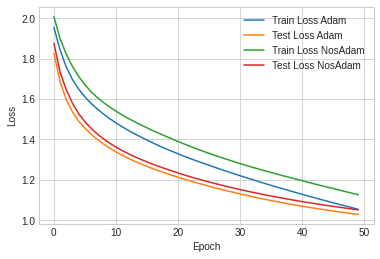

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

epochs = np.arange(0, 50, 1)

plt.plot(epochs, loss_all_train_adam, label='Train Loss Adam')
plt.plot(epochs, loss_all_test_adam, label='Test Loss Adam')
plt.plot(epochs, loss_all_train_nosadam, label='Train Loss NosAdam')
plt.plot(epochs, loss_all_test_nosadam, label='Test Loss NosAdam')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('cifar.pdf')

plt.show()